In [1]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_regression.csv")
data.head()

,Flipper Length (mm),Body Mass (g)
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
3,193.0,3450.0
4,190.0,3650.0


In [2]:
import seaborn as sns
sns.set_context("poster")

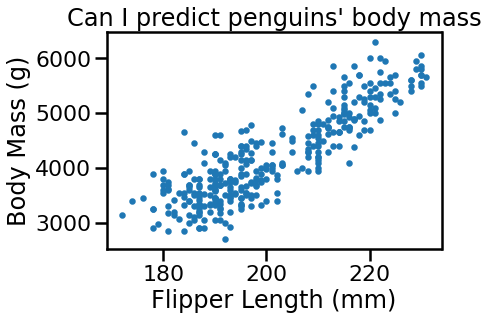

In [3]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
_ = ax.set_title("Can I predict penguins' body mass")

In [4]:
X, y = data[["Flipper Length (mm)"]], data[["Body Mass (g)"]]

In [5]:
X["Intercept"] = 1

In [6]:
X.head()

,Flipper Length (mm),Intercept
0,181.0,1
1,186.0,1
2,195.0,1
3,193.0,1
4,190.0,1


In [7]:
import numpy as np

coef = np.linalg.inv(X.T @ X) @ X.T @ y
coef

,Body Mass (g)
0,49.685566
1,-5780.831358


In [8]:
y_pred = np.dot(X, coef)
y_pred[:5]

array([[3212.25616143],
       [3460.68399346],
       [3907.85409111],
       [3808.4829583 ],
       [3659.42625908]])

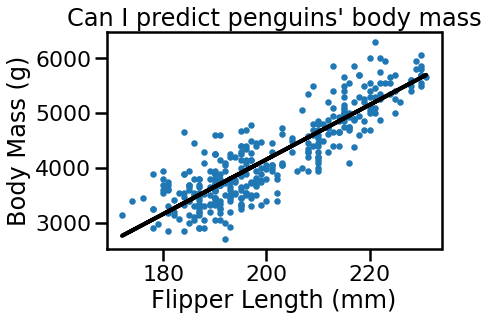

In [9]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
ax.plot(X["Flipper Length (mm)"], y_pred, color="black", linewidth=4)
_ = ax.set_title("Can I predict penguins' body mass")

In [10]:
class LinearRegression:
    def __init__(self, intercept=True):
        self.intercept = intercept
    def fit(self, X, y):
        if self.intercept:
            X = np.hstack(
                [X, np.ones((X.shape[0], 1))]
            )
        self.coef_ = coef = np.linalg.inv(X.T @ X) @ X.T @ y
        self._target_name = y.columns
        return self
    def predict(self, X):
        if self.intercept:
            X = np.hstack(
                [X, np.ones((X.shape[0], 1))]
            )
        return pd.DataFrame(
            np.dot(X, coef), columns=self._target_name
        )

In [11]:
model = LinearRegression(intercept=False)
model.fit(X, y).predict(X)

,Body Mass (g)
0,3212.256161
1,3460.683993
2,3907.854091
3,3808.482958
4,3659.426259
...,...
337,4504.080888
338,4255.653056
339,3808.482958
340,4653.137587


In [12]:
model.coef_

,Body Mass (g)
0,49.685566
1,-5780.831358


In [13]:
from sklearn.linear_model import LinearRegression

X, y = data[["Flipper Length (mm)"]], data["Body Mass (g)"]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
y_pred[:5]

array([3212.25616143, 3460.68399346, 3907.85409111, 3808.4829583 ,
       3659.42625908])

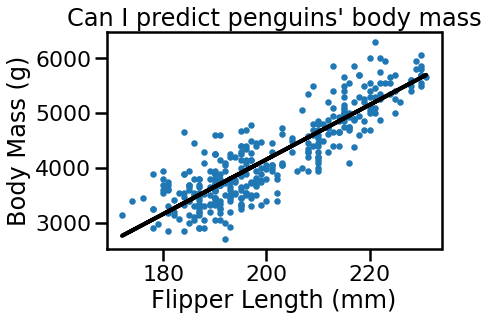

In [14]:
ax = data.plot.scatter(x=data.columns[0], y=data.columns[1])
ax.plot(X["Flipper Length (mm)"], y_pred, color="black", linewidth=4)
_ = ax.set_title("Can I predict penguins' body mass")

In [15]:
model.coef_, model.intercept_

(array([49.68556641]), -5780.831358077057)

In [16]:
from sklearn.metrics import r2_score

r2_score(y, model.predict(X))

0.7589925193571178

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [18]:
model.fit(X_train, y_train)

LinearRegression()

In [19]:
model.coef_, model.intercept_

(array([49.31531566]), -5703.699111619706)

In [20]:
r2_score(y_train, model.predict(X_train))

0.7659339940796758

In [21]:
r2_score(y_test, model.predict(X_test))

0.7356183787802288

In [22]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [23]:
r2_score(y_train, model.predict(X_train))

0.8427390867299657

In [24]:
r2_score(y_test, model.predict(X_test))

0.6533411607974651

In [25]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    model, X, y, cv=5,
    scoring="r2",
    return_train_score=True
)

In [26]:
cv_results = pd.DataFrame(cv_results)

In [27]:
cv_results[["train_score", "test_score"]]

,train_score,test_score
0,0.843680,-0.038305
1,0.837665,0.168886
2,0.801353,0.670892
3,0.751126,-0.034944
4,0.828035,-0.171509


In [28]:
cv_results[["train_score", "test_score"]].mean()

train_score    0.812372
test_score     0.119004
dtype: float64

In [29]:
cv_results[["train_score", "test_score"]].std()

train_score    0.037874
test_score     0.331630
dtype: float64

In [30]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_repeats=10, n_splits=3, random_state=0)
cv_results = cross_validate(
    model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True
)

In [31]:
cv_results = pd.DataFrame(cv_results)

In [32]:
cv_results[["train_score", "test_score"]]

,train_score,test_score
0,0.849589,0.639996
1,0.810334,0.771660
2,0.832746,0.688587
3,0.805736,0.773811
4,0.852157,0.676224
5,0.825057,0.758033
6,0.817333,0.748243
7,0.815459,0.763492
8,0.844852,0.695641
9,0.826664,0.682042


(0.0, 1.0)

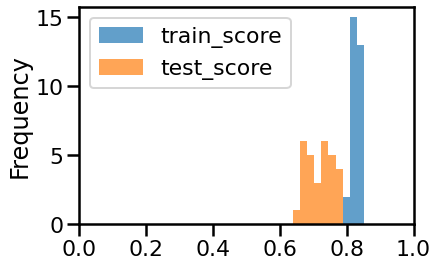

In [33]:
ax = cv_results[["train_score", "test_score"]].plot.hist(alpha=0.7)
ax.set_xlim([0, 1])

In [34]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
cv_results_dummy = cross_validate(
    dummy_model, X, y, cv=cv,
    scoring="r2",
    return_train_score=True
)
cv_results_dummy = pd.DataFrame(cv_results_dummy)

In [35]:
from sklearn.model_selection import permutation_test_score

model = DecisionTreeRegressor()
score, permutation_score, pvalue = permutation_test_score(
    model, X, y, cv=cv,
    n_jobs=-1, n_permutations=30
)
errors_permutation = pd.Series(permutation_score, name="Permuted error")

In [36]:
summary = pd.DataFrame()
summary["Tree test score"] = cv_results[["test_score"]]
summary["Dummy test score"] = cv_results_dummy[["test_score"]]
summary["Permuted error"] = errors_permutation

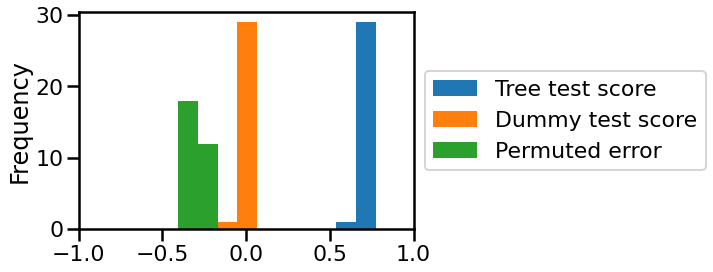

In [52]:
ax = summary.plot.hist()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
_ = ax.set_xlim([-1, 1])

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

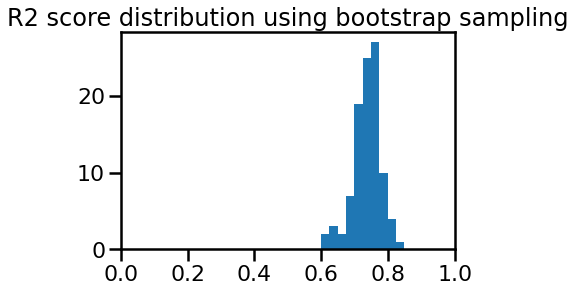

In [51]:
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
y_pred = model.predict(X_test)

n_bootstrap = 100
bootstrap_score = []
for _ in range(n_bootstrap):
    bootstrap_indices = rng.choice(
        np.arange(y_pred.size), size=y_pred.size, replace=True
    )
    bootstrap_score.append(
        r2_score(y_test.to_numpy()[bootstrap_indices], y_pred[bootstrap_indices])
    )
plt.hist(bootstrap_score)
plt.xlim([0, 1])
_ = plt.title("R2 score distribution using bootstrap sampling")